First Name: **Khushbu**

Last Name: **Saradva**

**HW1: Entropy-complexity Plane**

Group: mAIDA22, Data Science, 2022

### Complexity and entropy functions
In this section we will introduce entropy measure base on Shannon entropy and complexity measure base on Jensen-Shannon divergence.

In [1]:
shannon_entropy <- function(P) {
    P <- P[P != 0]
    return(-sum(P * log(P)))
}

entropic_measure <- function(P) {
    S_max <- shannon_entropy(rep(1, length(P)) / length(P))
    return(shannon_entropy(P) / S_max)
}

jensen_shannon_divergence <- function(P_1, P_2) {
    N <- length(P_1)
    Q_0 <- -2 / (((N + 1) / N * log(N + 1)) - 2 * log(2 * N) + log(N))
    return(Q_0 * (shannon_entropy((P_1 + P_2) / 2) - shannon_entropy(P_1) / 2 - shannon_entropy(P_2) / 2))
}

complexity <- function(P) {
    return(jensen_shannon_divergence(P, rep(1, length(P)) / length(P)) * entropic_measure(P))
}

### Borders
Borders of entropy-complexity plane.

In [2]:
min_borders <- function(d, n_steps = 500) {
    N <- factorial(d)
    d_step <- (1 - 1 / N) / n_steps

    p_min <- seq(1 / N, 1, d_step)
    min_complexity <- numeric(length(p_min))
    min_entropy <- numeric(length(p_min))

    for (i in seq_along(p_min)) {
        P <- c(p_min[i], rep((1 - p_min[i]) / (N - 1), N - 1))
        min_entropy[i] <- entropic_measure(P)
        min_complexity[i] <- complexity(P)
    }

    return(list(min_entropy, min_complexity))
}

max_borders <- function(d, n_steps = 500) {
    N <- factorial(d)
    d_step <- (1 - 1 / N) / n_steps

    max_complexity <- numeric(0)
    max_entropy <- numeric(0)

    for (i in seq_len(N - 1)) {
        p_max <- seq(0, 1 / (N - i), d_step)

        for (j in seq_along(p_max)) {
            P <- c(p_max[j], rep((1 - p_max[j]) / (N - i - 1), N - i - 1))

            if (length(P) != N) {
                P <- c(P, rep(0, i))
            }

            max_entropy <- c(max_entropy, entropic_measure(P))
            max_complexity <- c(max_complexity, complexity(P))
        }
    }

    return(list(max_entropy, max_complexity))
}

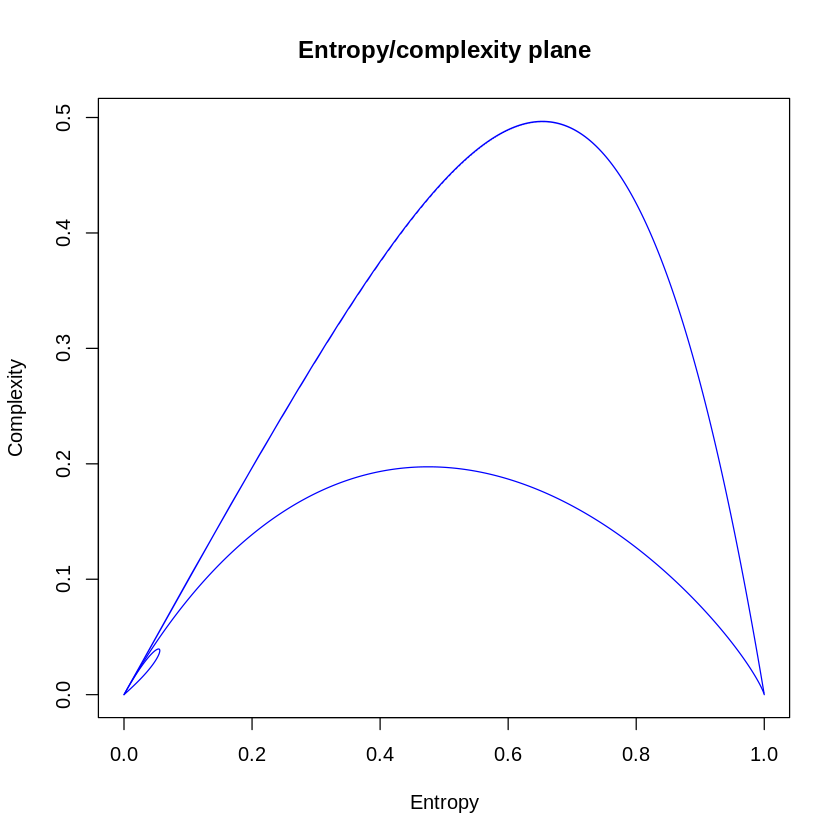

In [3]:
min_data <- min_borders(6)
X_min <- min_data[[1]]
y_min <- min_data[[2]]

max_data <- max_borders(6)
X_max <- max_data[[1]]
y_max <- max_data[[2]]

plot(X_max, y_max, type = "l", col = "blue", xlab = "Entropy",
    ylab = "Complexity", main = "Entropy/complexity plane", bg="white")
lines(X_min, y_min, col = "blue")

### Time series generator
Here we introduce functions for generating different time series. We will generate different chaotic time series, one noise and one regular time series.

In [4]:
# Skew tent map
skew_tent_map <- function(n = 10000, omega = 0.1847, x0 = 0.5) {
  x <- numeric(n)
  x[1] <- x0
  for (i in 2:n) {
    if (x[i-1] < omega) {
      x[i] <- x[i-1] / omega
    } else {
      x[i] <- (1 - x[i-1]) / (1 - omega)
    }
  }
  return(x)
}

# Logistic map
logistic_map <- function(n = 10000, r = 4, x0 = 0.4) {
  x <- numeric(n)
  x[1] <- x0
  for (i in 2:n) {
    x[i] <- r * x[i-1] * (1 - x[i-1])
  }
  return(x)
}

# Schuster's map
schuster_map <- function(n = 10000, z = 3/2, x0 = 0.5) {
  x <- numeric(n)
  x[1] <- x0
  for (i in 2:n) {
    x[i] <- x[i-1] + (x[i-1]^z)
    x[i] <- x[i] %% 1
  }
  return(x)
}

sine_data <- sin(seq(0, 100, 0.01))
gaussian_noise <- rnorm(1000)
schuster_map_data <- schuster_map()
logistic_map_data <- logistic_map()
skew_tent_map_data <- skew_tent_map()

### TimeSeries embedding
Use ordinal pattern embedding from the paper.

In [7]:
install.packages("combinat")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [8]:
library(combinat)

ordinal_pattern <- function(x, dim=6) {
    ordinal_numbers <- seq(0, (dim - 1), by = 1)
    possible_pattern <- (combinat::permn(ordinal_numbers))
    result <- 0
    result[1:length(possible_pattern)] <- 0

    for (i in 1:(length(x) - (dim - 1))) {
        temp <- x[i:(i + (dim - 1))]
        tempseq <- seq(0, dim - 1, by = 1)
        tempdata <- data.frame(temp, tempseq)
        tempdata <- tempdata[order(temp), ]

        for (j in 1:length(possible_pattern)) {
            if (all(possible_pattern[[j]] == tempdata$tempseq)) {
                result[j] <- result[j] + 1
            }
        }
    }

    return(result / (length(x) - (dim - 1)))
}


Attaching package: ‘combinat’


The following object is masked from ‘package:utils’:

    combn




In [9]:
sin_p <- ordinal_pattern(sine_data)

In [10]:
noise_p <- ordinal_pattern(gaussian_noise)

In [11]:
schuster_map_p <- ordinal_pattern(schuster_map_data)
logistic_map_p <- ordinal_pattern(logistic_map_data)
skew_tent_map_p <- ordinal_pattern(skew_tent_map_data)

### Plot plane with time series points

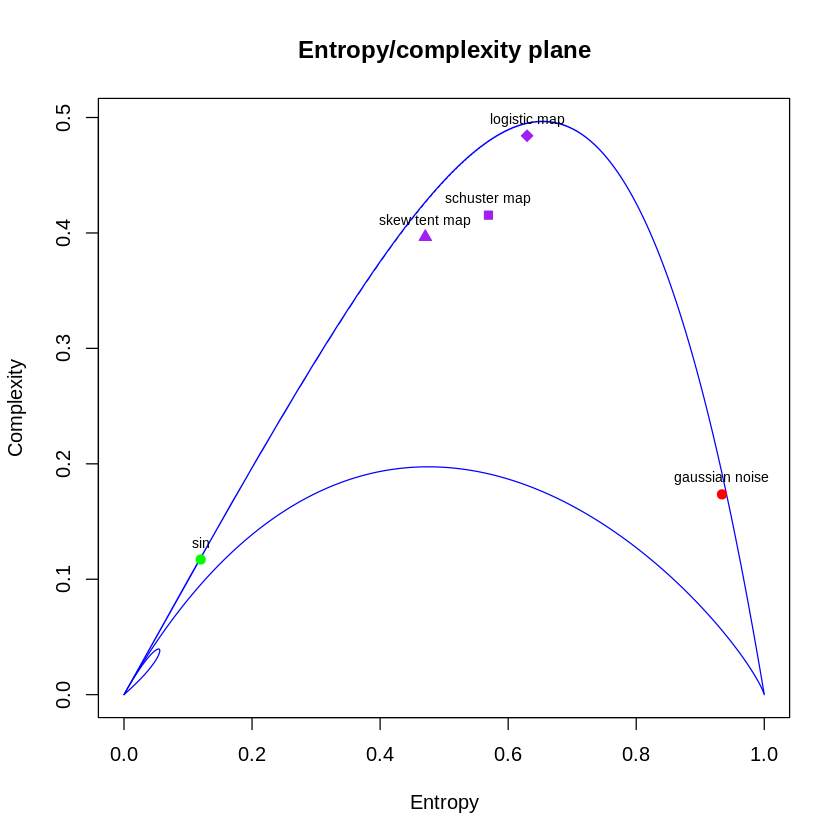

In [12]:
plot(X_max, y_max, type = "l", col = "blue", xlab = "Entropy",
    ylab = "Complexity", main = "Entropy/complexity plane", bg="white")
lines(X_min, y_min, col = "blue")

points(entropic_measure(noise_p), complexity(noise_p), col = "red", pch=19)
text(entropic_measure(noise_p), complexity(noise_p), labels="gaussian noise", cex= 0.7, pos=3)

points(entropic_measure(sin_p), complexity(sin_p), col = "green", bg="green", pch=19)
text(entropic_measure(sin_p), complexity(sin_p), labels="sin", cex= 0.7, pos=3)

points(entropic_measure(schuster_map_p), complexity(schuster_map_p), col = "purple", bg="purple", pch=22)
text(entropic_measure(schuster_map_p), complexity(schuster_map_p), labels="schuster map", cex= 0.7, pos=3)

points(entropic_measure(logistic_map_p), complexity(logistic_map_p), col = "purple", bg="purple", pch=23)
text(entropic_measure(logistic_map_p), complexity(logistic_map_p), labels="logistic map", cex= 0.7, pos=3)

points(entropic_measure(skew_tent_map_p), complexity(skew_tent_map_p), col = "purple", bg="purple", pch=24)
text(entropic_measure(skew_tent_map_p), complexity(skew_tent_map_p), labels="skew tent map", cex= 0.7, pos=3)